# Predicting online chess games

Importing libs

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
%matplotlib inline

Dataset = 'chess_games.csv' 
Avaliable at: https://www.kaggle.com/mysarahmadbhat/online-chess-games

<b>DATASET INFO - Columns:<b> 

<b>game_id</b>: type: int, unique match id.<br>
<b>rated</b>: type: bool, if the match is rated = true if not false.<br>
<b>turns</b>: type: int, qtd of turns.<br>
<b>victory_status</b>: type string, represents the type of victory move.<br>
<b>winner </b>:  type string, is the winner of the game, values: Black, White or Draw<br>
<b>time_increment</b>: type string, time used in minutes by each player.<br>
<b>white_id</b>: type string, name/id of the white player.<br>
<b>white_rating</b>: type int, game rating of the white player.<br>
<b>black_id</b>: type string, name/id of the black player.<br>
<b>black_rating</b>: type int, game rating of the black player.<br>
<b>moves</b>: type string, moves from the game.<br>
<b>opening_code</b>: not used<br>
<b>opening_moves</b>: not used<br>
<b>opening_fullname</b>: not used<br>
<b>opening_shortname</b>: not used<br>
<b>opening_response</b>: not used<br>
<b>opening_variation</b>: not used<br>

Created/edited after running the <b>transform.py</b> script:<br>    
<b>black_user_unique_id</b>: CREATED, type int, unique int unique id created based on the string black_id from original dataset<br>
<b>white_user_unique_id</b>: CREATED, type int, unique int unique id created based on the string white_id from original dataset<br>
<b>winner </b>: EDITED, type int, converted to int: 0 = Black, 1 = White, 2 = Draw.<br>

<b>Reading the first 5 lines of output.csv data:<b> 

In [2]:
data=pd.read_csv('output.csv',delimiter=',')

display(data.head())

,game_id,rated,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_code,opening_moves,opening_fullname,opening_shortname,opening_response,opening_variation,black_user_unique_id,white_user_unique_id
0,1,False,13,Out of Time,1,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,5,Slav Defense: Exchange Variation,Slav Defense,NaN,Exchange Variation,276007899197,236663457947
1,2,True,16,Resign,0,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,4,Nimzowitsch Defense: Kennedy Variation,Nimzowitsch Defense,NaN,Kennedy Variation,293209252596,308340708622
2,3,True,61,Mate,1,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,3,King's Pawn Game: Leonardis Variation,King's Pawn Game,NaN,Leonardis Variation,266980489497,276007899197
3,4,True,61,Mate,1,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,3,Queen's Pawn Game: Zukertort Variation,Queen's Pawn Game,NaN,Zukertort Variation,111711753589,794206812856
4,5,True,95,Mate,1,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,5,Philidor Defense,Philidor Defense,NaN,NaN,296516107568,203527055427


# Explorando as informações do dataset

<b>Coletando dados:</b>

In [3]:
games_total = matches = data.shape[0]

columns = data.shape[1] - 7

winner_black = len(data[data.winner==0])

winner_white = len(data[data.winner==1])

draw = len(data[data.winner==2])

black_win_rate = (float(winner_black)/(games_total)) *100

white_win_rate = (float(winner_white)/(games_total)) *100

draw_rate = (float(draw)/(games_total)) *100

match_winners = [winner_black, winner_white, draw]

# Apresentando informações: 

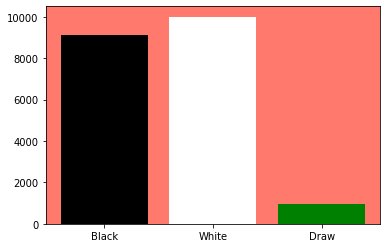

Total de partidas:  20058
Total de colunas utilizadas:  12
Total de partidas ganhos peças pretas: 9107, taxa: 45.403330342008175%.
Total de partidas ganhos peças brancas: 10001, taxa: 49.86040482600458%.
Total de empates: 950, taxa: 4.736264831987238%.


In [4]:
plot = np.arange(3)

plt.rcParams['axes.facecolor'] = 'xkcd:salmon'

plt.bar(plot, match_winners, color=['Black', 'White', 'Green'])

plt.xticks(plot, ('Black', 'White', 'Draw'))

plt.show()

print ('Total de partidas: ', games_total)
print ('Total de colunas utilizadas: ', columns)
print (f'Total de partidas ganhos peças pretas: {winner_black}, taxa: {black_win_rate}%.')
print (f'Total de partidas ganhos peças brancas: {winner_white}, taxa: {white_win_rate}%.')
print (f'Total de empates: {draw}, taxa: {draw_rate}%.')

In [5]:
num_data = data.drop(
    [
        'moves', 'opening_code', 'victory_status', 'time_increment', 'opening_moves', 'opening_fullname', 
        'opening_shortname','opening_response', 'opening_variation', 'white_id', 'black_id'
    ],
    1
)

display(num_data.head())

/tmp/ipykernel_8378/2953796330.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  num_data = data.drop(


,game_id,rated,turns,winner,white_rating,black_rating,black_user_unique_id,white_user_unique_id
0,1,False,13,1,1500,1191,276007899197,236663457947
1,2,True,16,0,1322,1261,293209252596,308340708622
2,3,True,61,1,1496,1500,266980489497,276007899197
3,4,True,61,1,1439,1454,111711753589,794206812856
4,5,True,95,1,1523,1469,296516107568,203527055427


In [6]:
#separa as features 
feat = num_data.drop(['winner'], 1)
print('Features', feat.head())

#separa as labels
labels = num_data['winner']
print('Labels', labels.head())

Features    game_id  rated  turns  white_rating  black_rating  black_user_unique_id  \
0        1  False     13          1500          1191          276007899197   
1        2   True     16          1322          1261          293209252596   
2        3   True     61          1496          1500          266980489497   
3        4   True     61          1439          1454          111711753589   
4        5   True     95          1523          1469          296516107568   

   white_user_unique_id  
0          236663457947  
1          308340708622  
2          276007899197  
3          794206812856  
4          203527055427  
Labels 0    1
1    0
2    1
3    1
4    1
Name: winner, dtype: int64


/tmp/ipykernel_8378/3076554818.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  feat = num_data.drop(['winner'], 1)


# Escolhendo as melhores features com Kbest (SelectKBest)

In [7]:
features_list = (
    'game_id', 'rated', 'white_user_unique_id', 'white_rating', 'black_user_unique_id', 'black_rating'
)

k_best_features = SelectKBest(k='all')

k_best_features.fit_transform(feat, labels)

k_best_features_scores = k_best_features.scores_

raw_pairs = zip(features_list[1:], k_best_features_scores)

ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])

best_features = k_best_features_final.keys()

print("Melhores features:")
print(k_best_features_final)

Melhores features:
{'white_rating': 320.117553614993, 'black_rating': 302.7205624697925, 'black_user_unique_id': 228.15554234209412, 'white_user_unique_id': 8.002775898174308, 'rated': 1.838394977570937}


# separa as features e labels com base nas melhores features para treinamento

In [8]:
features = num_data.drop(['winner','rated', 'turns'],1)
print('Features', features.head())

labels = num_data['winner']
print('Labels', labels.head())

Features    game_id  white_rating  black_rating  black_user_unique_id  \
0        1          1500          1191          276007899197   
1        2          1322          1261          293209252596   
2        3          1496          1500          266980489497   
3        4          1439          1454          111711753589   
4        5          1523          1469          296516107568   

   white_user_unique_id  
0          236663457947  
1          308340708622  
2          276007899197  
3          794206812856  
4          203527055427  
Labels 0    1
1    0
2    1
3    1
4    1
Name: winner, dtype: int64


/tmp/ipykernel_8378/4254308032.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features = num_data.drop(['winner','rated', 'turns'],1)


# Normalizando os dados de entrada(features)

# Gerando o novo padrão

In [9]:
scaler = MinMaxScaler().fit(features)
features_scale = scaler.transform(features)

print ('Features: ',features_scale.shape)
print (features_scale)

Features:  (20058, 5)
[[0.00000000e+00 3.73695198e-01 2.07859359e-01 1.96054618e-01
  1.52213868e-01]
 [4.98579050e-05 2.80793319e-01 2.44053775e-01 2.15221753e-01
  2.32082442e-01]
 [9.97158099e-05 3.71607516e-01 3.67631851e-01 1.85995550e-01
  1.96054618e-01]
 ...
 [9.99900284e-01 2.27035491e-01 2.56980352e-01 4.67379664e-01
  1.73821749e-01]
 [9.99950142e-01 3.00626305e-01 2.26473630e-01 2.60734833e-01
  1.79576617e-01]
 [1.00000000e+00 2.35386221e-01 2.84384695e-01 1.15987446e-01
  1.98146675e-01]]


# Separa em treinamento e teste

Separação manual para manter a ordem cronológica, uma vez que temos informação temporal. 

- Treino linhas 0 a 2000
- Teste linhas 2001 a 19057
- Previsão linhas 19058 a 20058

In [10]:
X_train = features_scale[:2000]
X_test = features_scale[2001:19057]

y_train = labels[:2000]
y_test = labels[2001:19057]

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

2000 2000
17056 17056


# Treinando e testando os modelos

- LogisticRegression

In [11]:
clf_LR = LogisticRegression(multi_class='multinomial',max_iter=2000)
clf_LR.fit(X_train, y_train)
pred = clf_LR.predict(X_test)

lg_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test,pred,average = 'micro')

print(f'Acurácia: {lg_acc}')
print(f'F1 Score: {lg_acc}')

Acurácia: 0.6099319887429644
F1 Score: 0.6099319887429644


- LogistRegression with hyper params

In [12]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid)

search.fit(X_train,y_train)

clf = search.best_estimator_

pred = clf.predict(X_test)

lg_acc = accuracy_score(y_test, pred)
f1=f1_score(y_test,pred,average = 'macro')

print(f'Acurácia: {lg_acc}')
print(f'F1 Score:{f1}')

print(f'best params: {clf}')

Acurácia: 0.6099319887429644
F1 Score:0.4148660293138033
best params: LogisticRegression(C=1, max_iter=1000)


- Support-vector machine (SVC)

In [13]:
clf = SVC()

clf.fit(X_train, y_train)

pred = clf.predict(X_test)

svc_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test,pred, average='micro')

print(f'Acurácia:{svc_acc}')
print(f'F1 Score:{f1}')

Acurácia:0.5242143527204502
F1 Score:0.5242143527204502


- SVC with hyper params

In [14]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

search = GridSearchCV(SVC(), param_grid)

search.fit(X_train,y_train)
clf_SVC = search.best_estimator_
pred= clf_SVC.predict(X_test)
acc = accuracy_score(y_test, pred)


f1=f1_score(y_test,pred,average = 'micro')

print(f'Acurácia:{acc}')
print(f'F1 Score:{f1}')
print(f'best params: {clf_SVC}')

Acurácia:0.5242143527204502
F1 Score:0.5242143527204502
best params: SVC(C=1)


- Decision Tree

In [15]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

pred= clf.predict(X_test)

dt_acc = accuracy_score(y_test, pred)
f1=f1_score(y_test,pred, average='macro')

print(f'Acurácia:{dt_acc}')
print(f'F1 Score:{f1}')


n_estimators = [10, 50, 100, 200]
max_depth = [3, 10, 20, 40]

Acurácia:0.487218574108818
F1 Score:0.357173879010201


- Decision tree with hyper parameters

In [16]:
param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12]
}

search = GridSearchCV(DecisionTreeClassifier(), param_grid)

search.fit(X_train,y_train)
clf = search.best_estimator_

pred = clf.predict(X_test)
dt_acc = accuracy_score(y_test, pred)


f1 = f1_score(y_test,pred,average = 'micro')

print(f'Acurácia:{dt_acc}')
print(f'F1 Score:{f1}')
print(f'best params: {clf}')

Acurácia:0.5419793621013134
F1 Score:0.5419793621013134
best params: DecisionTreeClassifier(max_depth=110, max_features=2, min_samples_leaf=5,
                       min_samples_split=8)


- Naive baeys

In [17]:
clf = GaussianNB()
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

nb_acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test,pred, average='micro')

print('Acurácia:{nb_acc}')
print('F1 Score:{f1}')

Acurácia:{nb_acc}
F1 Score:{f1}


# Executando a previsão

LogisticRegression obteve a melhor acurácia.

In [18]:
previsao = features_scale[19058:]

game_id_full = data['game_id']
game_id = game_id_full[19058:]

winner_full = data['winner']
winner = winner_full[19058:]

pred = clf_LR.predict(previsao)

df = pd.DataFrame({'real': winner, 'previsao':pred, 'game_id':game_id})

print(df)

       real  previsao  game_id
19058     1         0    19059
19059     1         1    19060
19060     0         0    19061
19061     0         1    19062
19062     0         0    19063
...     ...       ...      ...
20053     1         1    20054
20054     0         1    20055
20055     1         0    20056
20056     1         1    20057
20057     0         0    20058

[1000 rows x 3 columns]


# Apresentando resultados (confusion Matrix)

0 = Black winner, 1 = White winner, 2 = Draw


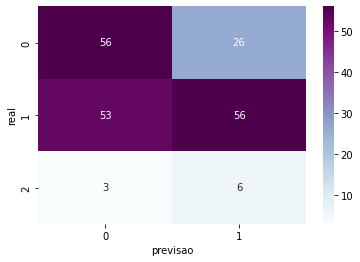

In [73]:
df = pd.DataFrame(df[:200], columns=['real','previsao'])

cf_matrix = pd.crosstab(df['real'], df['previsao'], rownames=['real'] , colnames=['previsao'])

sns.heatmap(cf_matrix, annot=True, cmap='BuPu')

print('0 = Black winner, 1 = White winner, 2 = Draw')